# B - Setup

In [41]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [42]:
# SpanBERT https://github.com/chriskhanhtran/spanish-bert
# Beto https://github.com/dccuchile/beto
# Multilingual https://github.com/google-research/bert/blob/master/multilingual.md#list-of-languages

# **PARAMETROS**

In [43]:
model         = 'SpanBERT'
dataset_name  = 'Total_15_19'      # [Total_15_19, Total_20_24, Total_25_29]
balanceo      = 'normal'            # [normal, over, under]
test_sz       = 0.1
learning_rate = 3e-5               # [5e-5, 3e-5, 2e-5]
num_epochs    = 10                  # [2,3,4,5,6,7,8,9,10]
rand_state    = 2020
flg_preproc   = 'processed'          #['original', 'processed']

In [44]:
dataset_path  = '/content/drive/MyDrive/DataSets/Tesis_Steph/'+ dataset_name +'.csv'
result_dir   =  '/content/drive/MyDrive/ResultadosEntrenamiento/Tesis_Steph_2/'+ dataset_name + '_PROC'+ flg_preproc  + '_MDL'+ model + '_BLC'+ balanceo +'_TS'+ str(test_sz) + '_RS'+ str(rand_state) +'_epch' + str(num_epochs) + '_lr' + str(learning_rate)

In [45]:
if model == 'base-uncased':
  path_model = 'bert-base-uncased'
elif model == 'SpanBERT':
  path_model = 'dccuchile/bert-base-spanish-wwm-uncased'
elif model == 'BETO':
  path_model = 'mrm8488/bert-spanish-cased-finetuned-ner'
elif model == 'multilingual':
  path_model = 'bert-base-multilingual-uncased'


print(path_model)

dccuchile/bert-base-spanish-wwm-uncased


## 1. Load Essential Libraries

In [46]:
#https://skimai.com/fine-tuning-bert-for-sentiment-analysis/
import os
import re
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## 2. Dataset

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
data = pd.read_csv(dataset_path, encoding= 'unicode_escape')
data.head(5)

,text,label,label_F,label_M,rango
0,"#PorqueMeQuedé,En qué se equivoca el Huffingto...",0,1,0,15-19
1,"#PorqueMeQuedé,""Si tú me ignoras, yo te ignora...",0,0,0,15-19
2,"#PorqueMeQuedé, ""En #ViolenciaDoméstica el te...",1,1,1,15-19
3,"#PorqueMeFui, 7 dolorosos años después, acepté...",1,1,1,15-19
4,"#PorqueMeQuedé,""porque creo que la gente puede...",1,1,1,15-19


### 2.1. Train - Test split

In [49]:
from sklearn.model_selection import train_test_split
X = data.text.values
y = data.label.values
X_TRAIN, X_test, y_TRAIN, y_test = train_test_split(X, y, test_size=test_sz, random_state=rand_state)
#X_TRAIN, X_test, y_TRAIN, y_test = train_test_split(X, y, test_size=test_sz, random_state=rand_state, stratify=y)

In [50]:
from collections import Counter
counter = Counter(y_TRAIN)
counter

Counter({0: 142, 1: 795})

In [51]:
from collections import Counter
counter = Counter(y_test)
counter

Counter({0: 20, 1: 85})

#### Extra: Balanceo

In [52]:
# Unir
np_train = []
for i in range(X_TRAIN.shape[0]):
  np_train.append([X_TRAIN[i],y_TRAIN[i]])

# Aquí le aplicamos el balanceo
df_TRAIN  = pd.DataFrame(np_train, columns=['text','label'])
val_count = df_TRAIN['label'].value_counts()

# Crear arrays
np_class_1 = df_TRAIN[df_TRAIN['label']==1].values.tolist()
np_class_0 = df_TRAIN[df_TRAIN['label']==0].values.tolist()
dif = len(np_class_1) - len(np_class_0)

# Pintar valores
print('0: ' + str(len(np_class_0)))
print('1: ' + str(len(np_class_1)))
print('dif: ' + str(dif))

0: 142
1: 795
dif: 653


In [53]:
np.random.seed(rand_state)
np_TRAIN = []
# Normal
if balanceo == 'normal':
  np_TRAIN = np_class_0 + np_class_1
  
elif balanceo == 'over':
  # RandomOverSampler -> Crear nuevos valores en la clase más pequeña (Clase 0) iguale a las clase mas grande (Clase 1)
  aux = np_class_0
  for i in range(dif):
    ran_index = random.randrange(0, len(np_class_0)-1, 1)
    aux.append(aux[ran_index])

  np_TRAIN = aux + np_class_1

elif balanceo == 'under':
  # RandomUnderSampler -> Hacer que la clase mas grande (Clase 1) sea igual a la clase más pequeña(Clase 0)
  num_ran = []
  for i in range(len(np_class_0)):
    num_ran.append(random.randrange(0, len(np_class_1)-1, 1))
  
  aux = []
  for r in num_ran:
    aux.append(np_class_1[r])

  np_TRAIN = np_class_0 + aux 

dfTRAIN = pd.DataFrame(np_TRAIN, columns=['text','label'])
dfTRAIN['label'].value_counts()

1    795
0    142
Name: label, dtype: int64

In [54]:
X_TRAIN = dfTRAIN.text.values
y_TRAIN = dfTRAIN.label.values

### 2.2. Train - valid Split

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X_TRAIN, y_TRAIN, test_size=test_sz, random_state=rand_state)

In [56]:
print('All dataset: ', data.shape[0])
print('Train: ', X_train.shape[0])
print('Valid: ', X_val.shape[0])
print('Test: ',+ X_test.shape[0])
print('Train + valid + test:', str(X_train.shape[0] + X_val.shape[0] + X_test.shape[0]))

All dataset:  1042
Train:  843
Valid:  94
Test:  105
Train + valid + test: 1042


In [57]:
import numpy as np

def plot_confusion_matrix(name_flag,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True
                          ):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(result_dir +'_' + name_flag +'_CM.png')
    plt.show()
    

In [58]:
from sklearn.metrics import accuracy_score, roc_curve, auc,classification_report,confusion_matrix

def evaluate_roc(probs, y_true, name_flag):
  #print(type(probs))
  #print(type(y_true))

  #print(len(probs))
  #print(len(y_true))

  #print(probs.shape)
  #print(y_true.shape)

  print(probs[0])
  print(type(probs[0]))
  """
  - Print AUC and accuracy on the test set
  - Plot ROC
  @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
  @params    y_true (np.array): an array of the true values with shape (len(y_true),)
  """
  preds = probs[:, 1]
  fpr, tpr, threshold = roc_curve(y_true, preds)
  roc_auc = auc(fpr, tpr)
  print(f'AUC: {roc_auc:.4f}')
      
  # Get accuracy over the test set
  y_pred = np.where(preds >= 0.5, 1, 0)
  accuracy = accuracy_score(y_true, y_pred)
  print(f'Accuracy: {accuracy*100:.2f}%')
  
  print(classification_report(y_true, y_pred, digits=4))
  
  #-----------Extra-----------
  labels       = [0 , 1]
  target_names = ['not_sick', 'sick']
  report = classification_report(y_true, y_pred, labels = labels,target_names=target_names,digits=4, output_dict=True)
      
  accuracy    = report['accuracy']
  sensitivity = report['not_sick']['recall'] 
  especifity  = report['sick']['recall']    
  
  print(result_dir)
  print('Acc: ', str(round(accuracy,4)))
  print('Spe: ', str(round(especifity,4)))
  print('Sen: ', str(round(sensitivity,4)))
  print('AUC: ', str(round(roc_auc,4)))
  print('')
  #---------------------------

  # Plot ROC AUC
  plt.figure(1)
  plt.rcParams["figure.figsize"] = 7,7
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  fig_accu =  plt.figure(1) 
  plt.show()
  
  #Dividir probs
  probs_x = []
  probs_y = []

  for prob in probs:
    probs_x.append(prob[0])
    probs_y.append(prob[1])

  #Save probs, y_true
  df_a = pd.DataFrame(probs_x, columns = ['probs_x'])
  df_b = pd.DataFrame(probs_y, columns = ['probs_y'])
  df_c = pd.DataFrame(y_true, columns = ['y_true'])
                      
  frames = [df_a,df_b, df_c]
  df = pd.concat(frames, axis=1)
  
  print(confusion_matrix(y_true, y_pred))
  #plot_confusion_matrix(name_flag,
  #                      confusion_matrix(y_true, y_pred),
  #                      target_names = ['Class 0', 'Class 1'],
  #                      title='Confusion matrix',
  #                      cmap=None,
  #                      normalize=False
  #                      )
  
  fig_accu.savefig(result_dir +'_' + name_flag +'_ROC-AUC.png')
  df.to_csv(result_dir +'_' +  name_flag +'_History.csv', index=False)

# D - Fine-tuning BERT

## 1. Install the Hugging Face Library

In [59]:
!pip install transformers==4.4.2
#2.8.0

# 2. Tokenization and Input Formatting

In [60]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    if flg_preproc == 'processed':
      # Remove '@name'
      text = re.sub(r'(@.*?)[\s]', ' ', text)

      # Replace '&amp;' with '&'
      text = re.sub(r'&amp;', '&', text)

      # Replace '&amp' with '&'
      text = re.sub(r'&amp', '&', text)

      # Replace " with ''
      text = re.sub(r'"', '', text)

      # Remove trailing whitespace
      text = re.sub(r'\s+', ' ', text).strip()
      
      # Replace HashTags
      text = re.sub(r'PorqueMeQuedé', 'Por qué me quedé', text)
      text = re.sub(r'PorqueMeFui', 'Por qué me fui', text)
      text = re.sub(r'NoMas', 'no mas', text)
      text = re.sub(r'nomas', 'no mas', text)
      text = re.sub(r'NuncaMás', 'Nunca Más', text)
      text = re.sub(r'NuncaMas', 'Nunca Más', text)
      text = re.sub(r'nuncamas', 'Nunca Más', text)
      text = re.sub(r'#', '', text)
    
    return text

In [61]:
# Print sentence 0
print('Original: ', X_train[0])
print('Processed: ', text_preprocessing(X_train[0]))

Original:  #PorqueMeFui, La mirada fría en sus ojos  me amenazaba.
Processed:  Por qué me fui, La mirada fría en sus ojos me amenazaba.


### 2.1. BERT Tokenizer

In [62]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(path_model, do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,             # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Before tokenizing, we need to specify the maximum length of our sentences.

In [63]:
# Concatenate train data and test data
all_tweets = np.concatenate([X_train, X_test, X_val])

# Encode our concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  74


Now let's tokenize our data.

In [64]:
# Specify `MAX_LEN`
MAX_LEN = max_len

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X_train[0]])[0].squeeze().numpy())
print('Original: ', X_train[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  #PorqueMeFui, La mirada fría en sus ojos  me amenazaba.
Token IDs:  [4, 1076, 1140, 1094, 3889, 1019, 1032, 8265, 9259, 1035, 1233, 3154, 1094, 5783, 1152, 1008, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


### 2.2. Create PyTorch DataLoader

In [65]:
print(train_inputs.shape)
print(val_inputs.shape)

torch.Size([843, 74])
torch.Size([94, 74])


We will create an iterator for our dataset using the torch DataLoader class. This will help save on memory during training and boost the training speed.

In [66]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

## 3. Train Our Model

### 3.1. Create BertClassifier

In [67]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 2

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained(path_model)

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 51 µs, sys: 13 µs, total: 64 µs
Wall time: 69.9 µs


### 3.2. Optimizer & Learning Rate Scheduler

To fine-tune our Bert Classifier, we need to create an optimizer. The authors recommend following hyper-parameters:

- Batch size: 16 or 32
- Learning rate (Adam): 5e-5, 3e-5 or 2e-5
- Number of epochs: 2, 3, 4

Huggingface provided the [run_glue.py](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109) script, an examples of implementing the `transformers` library. In the script, the AdamW optimizer is used.

In [68]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=learning_rate,         #5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

### 3.3. Training Loop

In [69]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

Now, let's start training our BertClassifier!

In [70]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler = initialize_model(epochs=num_epochs)
#train(bert_classifier, train_dataloader, val_dataloader, epochs=num_epochs, evaluation=True)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.4. Evaluation on Validation Set

In [71]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [72]:
# Compute predicted probabilities on the test set
probs = bert_predict(bert_classifier, val_dataloader)

In [73]:
# Evaluate the Bert classifier
# evaluate_roc(probs, y_val,'valid')

# 3.5. Train Our Model on the Entire Training Data

In [74]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=batch_size)

# Train the Bert Classifier on the entire training data
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=num_epochs)
train(bert_classifier, full_train_dataloader, epochs=num_epochs)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.442191   |     -      |     -     |   5.74   
   1    |   29    |   0.411954   |     -      |     -     |   2.29   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |   20    |   0.322307   |     -      |     -     |   5.74   
   2    |   29    |   0.286819   |     -      |     -     |   2.28   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |   20    |   0.197896   |     -      |     -     |   5.71   
   3    |   29    |   0.226573   |     -      |     -     |   

## 4. Predictions on Test Set

### 4.1. Data Preparation

Before making predictions on the test set, we need to redo processing and encoding steps done on the training data. Fortunately, we have written the `preprocessing_for_bert` function to do that for us.

In [75]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

Tokenizing data...


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# 4.2. **PREDICCION**

Number of tweets predicted non-negative:  96
[0.00355247 0.99644744]
<class 'numpy.ndarray'>
AUC: 0.8535
Accuracy: 87.62%
              precision    recall  f1-score   support

           0     0.8889    0.4000    0.5517        20
           1     0.8750    0.9882    0.9282        85

    accuracy                         0.8762       105
   macro avg     0.8819    0.6941    0.7400       105
weighted avg     0.8776    0.8762    0.8565       105

/content/drive/MyDrive/ResultadosEntrenamiento/Tesis_Steph_2/Total_15_19_PROCprocessed_MDLSpanBERT_BLCnormal_TS0.1_RS2020_epch10_lr3e-05
Acc:  0.8762
Spe:  0.9882
Sen:  0.4
AUC:  0.8535



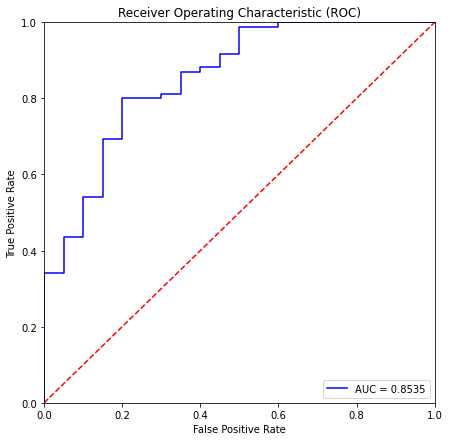

[[ 8 12]
 [ 1 84]]


In [79]:
# Compute predicted probabilities on the test set
probs_test = bert_predict(bert_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.9
preds_test = np.where(probs_test[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of tweets predicted non-negative: ", preds_test.sum())
#print(result_dir)

# Evaluate the Bert classifier
evaluate_roc(probs_test, y_test,'test')

In [77]:
output = X_test[preds_test==1]
for i in range(20):
  print(output[i])

#PorqueMeQuedé,Estaba embarazada cuando me golpeó. Aquí . http://t.co/cmJcbKZ7Tj a través de @thedailybeast
#PorqueMeQuedé, Nunca dejaré que un hombre me vuelva a hacer eso @WhyILeft pero irse tomó de MUCHA fuerza/coraje. #NuncaMás
#PorqueMeQuedé," no culpar a la víctima ,es crear conciencia, prevenir la culpabilidad de las víctimas, &amp
#PorqueMeQuedé,"   Él me hizo creer que yo era la única que podía ayudarlo a ""mejorar"". Pensé que debería estar allí por nuestras hija."
#PorqueMeFui,"  Trato de matarme.  La policia se puso de su lado.  Él mintió, dijo que tomé el dinero nuestro hijo.  Nuestro hijo nunca tuvo ninguno."
#PorqueMeQuedé,"Él se aseguró de que no tuviera amigos y familia limitada a la que acudir. ""Él era todo lo que tenía"" ."
#PorqueMeQuedé,"Mis amigos dijeron que yo estaba mintiendo, que no había manera de que él me hiciera eso, que era "una trampa". Nadie se tomó el tiempo para ver mis moretones. "
"PorqueMeQuedé,"Si me encuentro con él, no hay nada que pueda hacer 

# E - Conclusion

## Guardar Modelo

In [78]:
PATH_SAVE_MODEL_1 =  result_dir + '_model1.pth' 
torch.save(bert_classifier, PATH_SAVE_MODEL_1)
print(PATH_SAVE_MODEL_1)

/content/drive/MyDrive/ResultadosEntrenamiento/Tesis_Steph_2/Total_15_19_PROCprocessed_MDLSpanBERT_BLCnormal_TS0.1_RS2020_epch10_lr3e-05_model1.pth
